# Example
"Spectral Analysis for physical applications Multitaper and Cnventional Univariate Techniques", Donald B. Percival and Andrew T. Walden


In [1]:
from scipy.signal import lfilter
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

from src.multitaper import MultiTaper_Periodogram #適宜変更


self.k_DPS, self.eigenvalues,self.Jk, self.Smt_k, self.Smt, f


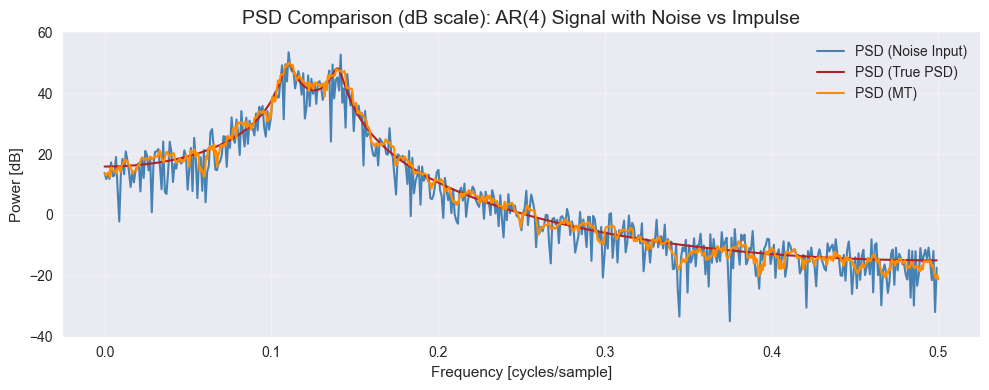

In [2]:
# Generating PSD comparison for AR(4) signal using FFT, Multitaper, and theoretical model
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, windows

# AR(4) coefficients from image
ar_coeffs = np.array([2.7607, -3.8106, 2.6535, -0.9238])
A = np.r_[1, -ar_coeffs]
fs = 1.0
npts = 1024
rng = np.random.default_rng(42)

# Noisy AR signal
sigma = 0.1
c = 20.0
epsilon = rng.normal(0, sigma, npts)
x_noise = lfilter([1.0], A, epsilon) * c

# FFT-based PSD
nfft = 1024
freqs = np.fft.fftfreq(nfft, d=1/fs)
psd_noise = np.abs(np.fft.fft(x_noise, n=nfft))**2 / (fs*npts)

# Multitaper PSD
NW = 3.5
K = int(2*NW - 1)
tapers, eigvals = windows.dpss(npts, NW, Kmax=K, return_ratios=True)
Jk = np.fft.fft(tapers * x_noise[np.newaxis,:], n=nfft, axis=1)
Smt_k = np.abs(Jk)**2 / (fs * npts)
weights = eigvals / np.sum(eigvals)
psd_mt = np.sum(weights[:, None] * Smt_k, axis=0)

# True PSD from AR model
f = freqs[:nfft//2]
omega = 2*np.pi*f
Az = (A[0]
      + A[1]*np.exp(-1j*omega)
      + A[2]*np.exp(-1j*2*omega)
      + A[3]*np.exp(-1j*3*omega)
      + A[4]*np.exp(-1j*4*omega))
var_eff = (sigma**2) * (c**2)
psd_true = var_eff / (np.abs(Az)**2)

# FFT and PSD
nfft = 1024
freqs = np.fft.fftfreq(nfft, d=1)
psd_noise = np.abs(np.fft.fft(x_noise, n=nfft))**2 / (fs*npts)

# マルチターパーPSD推定とF検定
MT_psd = MultiTaper_Periodogram(NW=3.5, K=5, nfft=2**12)
MT_psd.MT_Spec(x_noise, fs)                 
# MT_psd.Harmonic_Ftest(p_level=0.05)
# print(MT_psd.Smt_k)
# dB変換
psd_noise_db = 10 * np.log10(psd_noise[:nfft//2])
Smt_db = 10 * np.log10(MT_psd.Smt)
psd_true_db = 10 * np.log10(psd_true)

# プロット
# Plotting
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freqs[:nfft//2], psd_noise_db, label='PSD (Noise Input)', color='steelblue', lw=1.5)
ax.plot(freqs[:nfft//2], psd_true_db, label='PSD (True PSD)', color='firebrick', lw=1.5)
ax.plot(MT_psd.f, Smt_db, label='PSD (MT)', color='darkorange', lw=1.5)

ax.set_title('PSD Comparison (dB scale): AR(4) Signal with Noise vs Impulse', fontsize=14)
ax.set_xlabel('Frequency [cycles/sample]')
ax.set_ylabel('Power [dB]')
ax.grid(True, alpha=0.3)
ax.set_ylim(-40,60)
ax.legend()
plt.tight_layout()
plt.show()


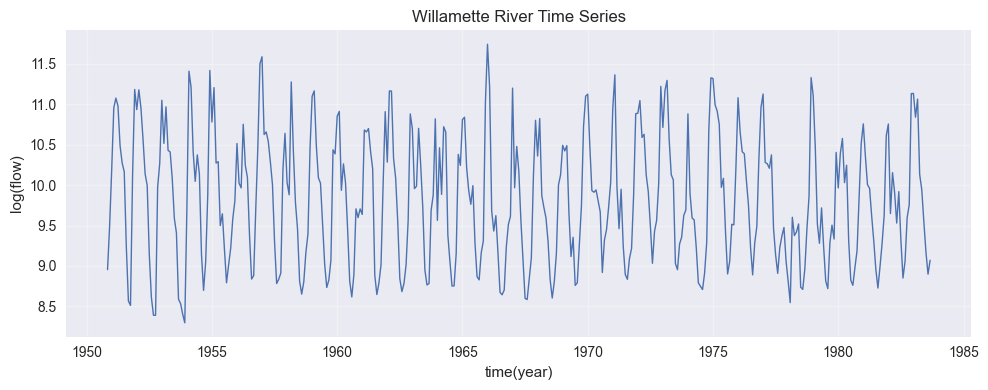

In [3]:
Willamette_data = np.loadtxt("https://faculty.washington.edu/dbp/DATA/Willamette.dat", comments="C")
# サンプル数と時間軸
npts = len(Willamette_data)        # 395
start_year = 1950 + 10/12          # 1950年10月 = 1950 + 10/12 ≈ 1950.83
dt = 1/12                          # 1サンプル = 1ヶ月 = 1/12年
time_axis = start_year + np.arange(npts) * dt
# プロット
plt.figure(figsize=(10,4))
plt.plot(time_axis, Willamette_data, lw=1)
plt.title("Willamette River Time Series")
plt.xlabel("time(year)")
plt.ylabel("log(flow)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

self.k_DPS, self.eigenvalues,self.Jk, self.Smt_k, self.Smt, f


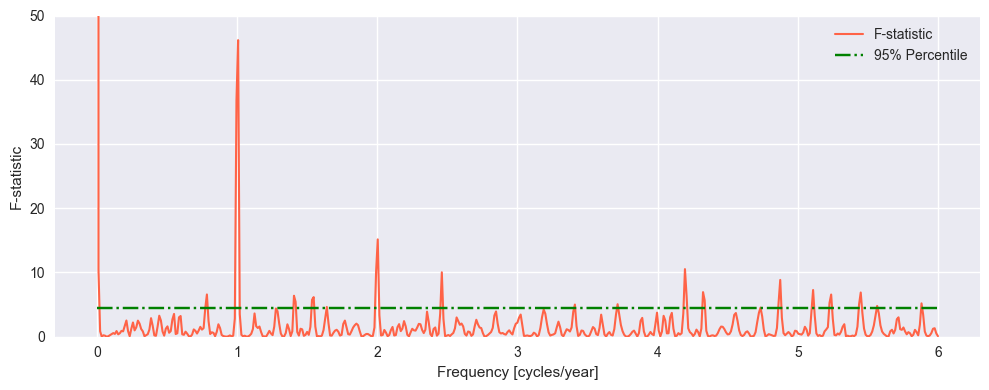

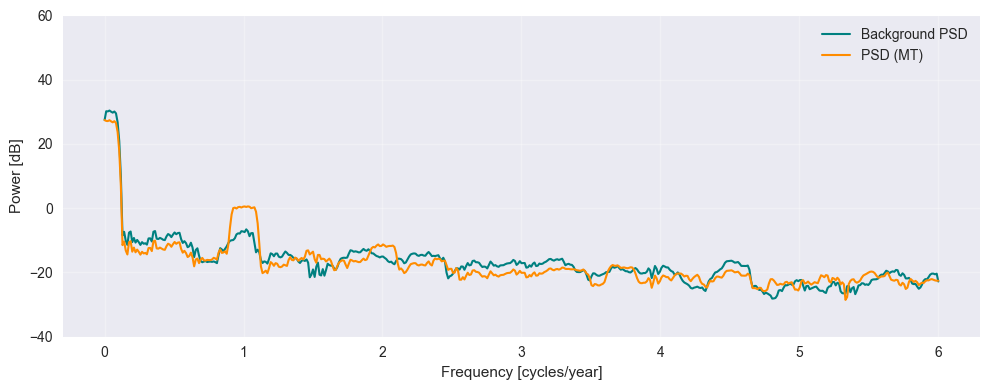

In [12]:
# マルチターパーPSD推定とF検定
MT_psd = MultiTaper_Periodogram(NW=4, K=5, nfft=1024)
MT_psd.MT_Spec(Willamette_data, fs=1/dt)                 
MT_psd.Harmonic_Ftest(p_level=0.05)
# print(MT_psd.Smt_k)
# dB変換
Smt_db = 10 * np.log10(MT_psd.Smt)
Re_Smt_db = 10 * np.log10(MT_psd.re_psd[0, :])

# # F統計量のプロット
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
ax.plot(MT_psd.f, MT_psd.F_stat[0, :], '-', label='F-statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MT_psd.F_crit, MT_psd.f[0], MT_psd.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [cycles/year]')
# ax.set_xlim(0, 0.1)  # 周波数範囲を cycles/year に合わせて調整
ax.set_ylim(0, 50)
ax.legend()
fig.tight_layout()
plt.show()

# プロット
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(MT_psd.f, Re_Smt_db, '-', label='Background PSD', alpha=1, c='teal', lw=1.5)
ax.plot(MT_psd.f, Smt_db, label='PSD (MT)', color='darkorange', lw=1.5)
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylabel('Power [dB]')
ax.grid(True, alpha=0.3)
ax.set_ylim(-40,60)
ax.legend()
plt.tight_layout()
plt.show()

C:\Users\chamu\AppData\Local\Temp\ipykernel_35096\1602431202.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,1e5)


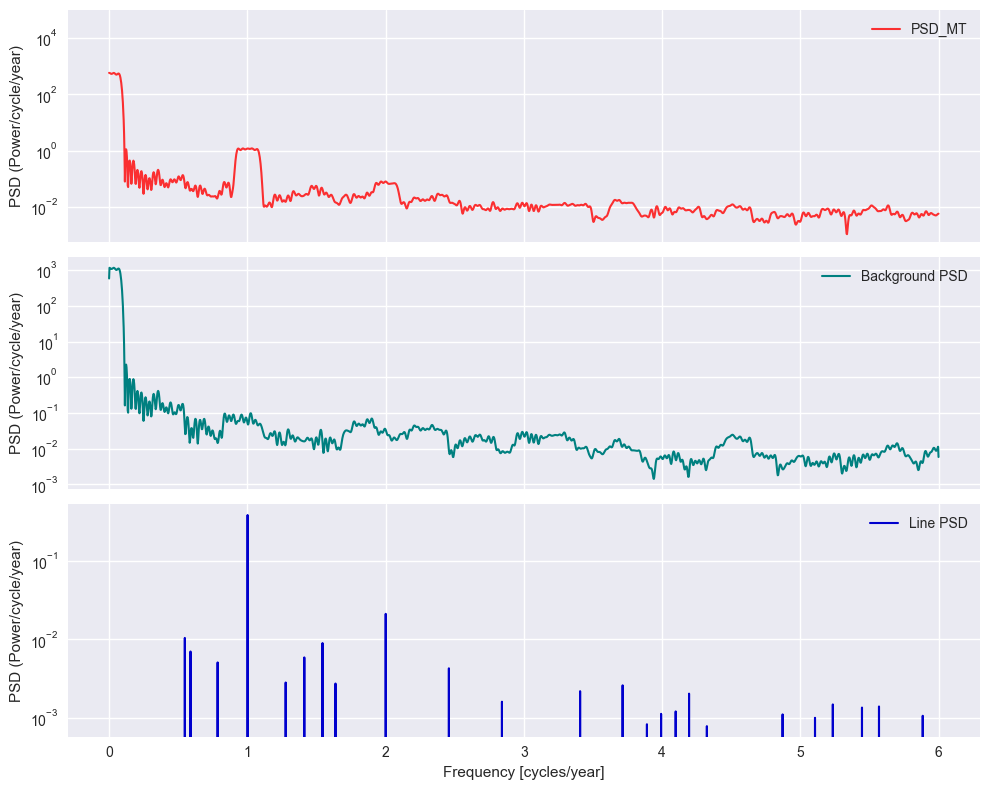

In [5]:

# PSDと再構成スペクトルのプロット
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# ① PSD_MTと再構成PSD
ax = axes[0]
ax.plot(MT_psd.f, MT_psd.Smt, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.set_ylabel('PSD (Power/cycle/year)')
ax.set_yscale("log")
# ax.set_xlim(0, 0.1)  # 例: 周波数範囲を cycles/year に合わせて調整
ax.set_ylim(0,1e5)
ax.legend()

# ② バックスペクトル（線成分除去後）
ax = axes[1]
ax.plot(MT_psd.f, MT_psd.re_psd[0, :], '-', label='Background PSD', alpha=1, c='teal', lw=1.5)
ax.set_ylabel('PSD (Power/cycle/year)')
ax.set_yscale("log")
ax.legend()

# ③ 線成分スペクトルのみ
ax = axes[2]
ax.plot(MT_psd.f, MT_psd.re_psd[2, :], '-', label='Line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/cycle/year)')
ax.set_xlabel('Frequency [cycles/year]')
ax.set_yscale("log")
ax.legend()

fig.tight_layout()
plt.show()


In [6]:
# import matplotlib.pyplot as plt
# import numpy as np

# from src.multitaper import get_data #適宜変更
# # データ読み込みと時間軸生成
# x = get_data('v22_174_series.dat')
# npts = np.shape(x)[0]
# dt   = 4930  # サンプリング間隔 [years]
# t    = np.arange(npts) * dt
# print('Load sediment core data')
# print('Number of points and dt ', npts, dt)

# # 元信号のプロット
# fig = plt.figure(figsize=(10, 2))
# ax = fig.add_subplot()
# ax.plot(t / 1e3, x, label="AM Signal", color='b')
# ax.set_xlabel("Time [kyr]")   # ← 単位を「千年」に修正
# ax.set_ylabel("Amplitude")
# ax.set_ylim(-1.0,1.0)
# ax.grid()
# plt.tight_layout()
# plt.show()

# # サンプリング周波数 [cycles/year]
# fs = 1.0 / dt

# # マルチターパーPSD推定とF検定
# MT_psd = MultiTaper_Periodogram(NW=3.5, K=5, nfft=2**12)
# MT_psd.MT_Spec(x, fs)                 # ← fs = 1/dt を渡す
# MT_psd.Harmonic_Ftest(p_level=0.05)


# # PSDと再構成スペクトルのプロット
# fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# # ① PSD_MTと再構成PSD
# ax = axes[0]
# ax.plot(MT_psd.f, MT_psd.Smt, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
# ax.set_ylabel('PSD (Power/cycle/year)')
# ax.set_yscale("log")
# # ax.set_xlim(0, 0.1)  # 例: 周波数範囲を cycles/year に合わせて調整
# ax.set_ylim(0,1e5)
# ax.legend()

# # ② バックスペクトル（線成分除去後）
# ax = axes[1]
# ax.plot(MT_psd.f, MT_psd.re_psd[0, :], '-', label='Background PSD', alpha=1, c='teal', lw=1.5)
# ax.set_ylabel('PSD (Power/cycle/year)')
# ax.set_yscale("log")
# ax.legend()

# # ③ 線成分スペクトルのみ
# ax = axes[2]
# ax.plot(MT_psd.f, MT_psd.re_psd[2, :], '-', label='Line PSD', alpha=1, c='mediumblue', lw=1.5)
# ax.set_ylabel('PSD (Power/cycle/year)')
# ax.set_xlabel('Frequency [cycles/year]')
# ax.set_yscale("log")
# ax.legend()

# fig.tight_layout()
# plt.show()

# # F統計量のプロット
# fig = plt.figure(figsize=(12, 2))
# ax = fig.add_subplot()
# ax.plot(MT_psd.f, MT_psd.F_stat[0, :], '-', label='F-statistic', alpha=1, c='tomato', lw=1.5)
# ax.hlines(MT_psd.F_crit, MT_psd.f[0], MT_psd.f[-1], linestyles="-.", color='green', label='95% Percentile')
# ax.set_ylabel('F-statistic')
# ax.set_xlabel('Frequency [cycles/year]')
# # ax.set_xlim(0, 0.1)  # 周波数範囲を cycles/year に合わせて調整
# ax.set_ylim(0, 20)
# ax.legend()
# fig.tight_layout()
# plt.show()


In [7]:
# from multitaper import MTSpec, MTCross, MTSine, SineCross
# import multitaper.utils as utils

# # Define desired parameters
# #------------------------------------------------
# nw    = 3.5
# kspec = 5 

# fig = plt.figure(1)
# ax  = fig.add_subplot()
# ax.plot(t/1000,x)
# ax.set_xlabel('time (kyear)')

# #------------------------------------------------
# # Get MTSPEC
# #     Get reshape spectrum with F test
# #     Get confidence intervals
# #     Get QI spectrum
# #------------------------------------------------

# print('Create MTSPEC class for your data')
# psd = MTSpec(x,nw,kspec,dt,iadapt=1, nfft=2^14)
# print('Type of psd ', type(psd))

# #------------------------------------------------
# # Reshape spectrum
# #------------------------------------------------
# F,p = psd.ftest()
# respec, spec_noline, yk, sline = psd.reshape(fcrit=0.90,p=p)
# #------------------------------------------------
# # Confidence intervals
# #------------------------------------------------
# # spec_ci = psd.jackspec()
# #------------------------------------------------
# # QI inverse spectrum
# #------------------------------------------------
# # qispec  = psd.qiinv()[0]

# # Plot only positive frequencies
# freq ,spec               = psd.rspec()
# # freq,qispec,spec_ci      = psd.rspec(qispec,spec_ci)
# k_yk = np.mean(np.abs(yk)**2, axis=1)[:,np.newaxis]

# freq,respec,spec_noline,sline,k_yk  = psd.rspec(respec,spec_noline,sline,k_yk)

# F = F[0:psd.nf]

# fig = plt.figure(2)
# ax  = fig.add_subplot()
# ax.semilogy(freq*1e6,spec, 'r',alpha=0.8, label="lib")
# ax.semilogy(MT_psd.f*1e6, MT_psd.Smt, 'c',alpha=0.6,label="My")
# # ax.semilogy(freq*1e6,spec_ci,'k--')
# # ax.semilogy(freq*1e6,qispec,'r--')
# ax.set_title('Spectrum estimate')
# ax.set_xlim(0, 100)
# ax.set_ylim(1,1e5)
# ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
# ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')

# fig = plt.figure(3)
# ax  = fig.add_subplot()
# ax.plot(freq*1e6,F, 'r',alpha=0.8)
# ax.plot(MT_psd.f*1e6, MT_psd.F_stat[0, :], 'c',alpha=0.6)
# ax.hlines(MT_psd.F_crit, MT_psd.f[0]*1e6, MT_psd.f[-1]*1e6, linestyles="-.", color='green', label='95% Percentile')

# ax.set_xlim(0,100)
# ax.set_title(r'$F$ statistic for periodic components')
# ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
# ax.set_ylabel(r'F-statistic for periodic lines')
# #plt.ylim(-0.5,14.5)

# fig = plt.figure(4)
# ax  = fig.add_subplot()
# ax.semilogy(freq*1e6,respec)
# ax.semilogy(MT_psd.f*1e6, MT_psd.re_psd[1,:])
# ax.semilogy(freq*1e6, k_yk*dt, 'navy',alpha=0.6)
# ax.set_xlim(0,100)
# ax.set_title(r'Reshaped spectrum')
# ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
# ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')
# #plt.ylim(-0.5,14.5)
# fig = plt.figure(5)
# ax  = fig.add_subplot()
# ax.semilogy(freq*1e6,sline)
# ax.semilogy(MT_psd.f*1e6, MT_psd.re_psd[2,:])
# ax.set_xlim(0,100)
# ax.set_title(r'Reshaped spectrum')
# ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
# ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')
# ax.legend()
# plt.show()